# Liesel-GAM Demo Notebook

## Setup and Imports

In [22]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam
from liesel_gam.builder.consolidate_bases import consolidate_bases, evaluate_bases

In [23]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True non-separable smooth ----
    def f_true(x, y):
        return (
            1.5 * np.sin(2 * np.pi * x) * np.cos(3 * np.pi * y)
            + 0.8 * x * y
            + 2.0 * np.exp(-(((x - 0.65) ** 2) / 0.01 + ((y - 0.35) ** 2) / 0.06))
        )

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [24]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.935849  0.689560
1  0.438878  0.761433  0.621075  0.405865
2  0.858598  0.903328  1.334100  1.948456
3  0.697368  0.720696 -0.674870 -0.224435
4  0.094177  0.963211 -0.714339 -0.817277


In [25]:
df_grid = gen_tp_data(n=5000, grid=True)

In [26]:
df_grid

,x,y,eta,z
0,0.000000,0.0,1.162528e-19,0.103675
1,0.014286,0.0,1.344590e-01,0.380944
2,0.028571,0.0,2.678353e-01,0.366966
3,0.042857,0.0,3.990553e-01,0.008108
4,0.057143,0.0,5.270622e-01,0.798669
...,...,...,...,...
5036,0.942857,1.0,1.281348e+00,1.076909
5037,0.957143,1.0,1.164770e+00,1.171729
5038,0.971429,1.0,1.044978e+00,1.027468
5039,0.985714,1.0,9.230304e-01,0.818835


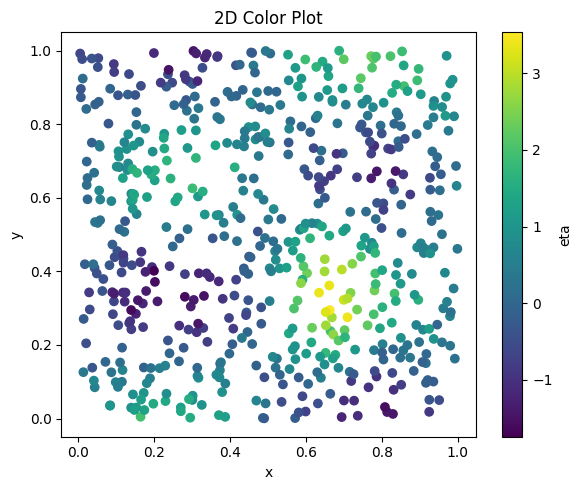

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

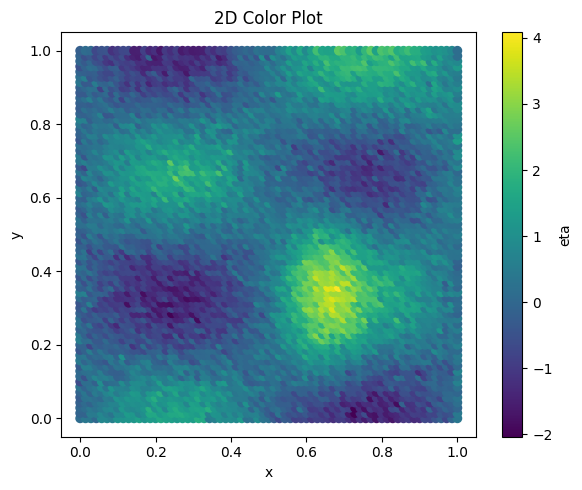

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

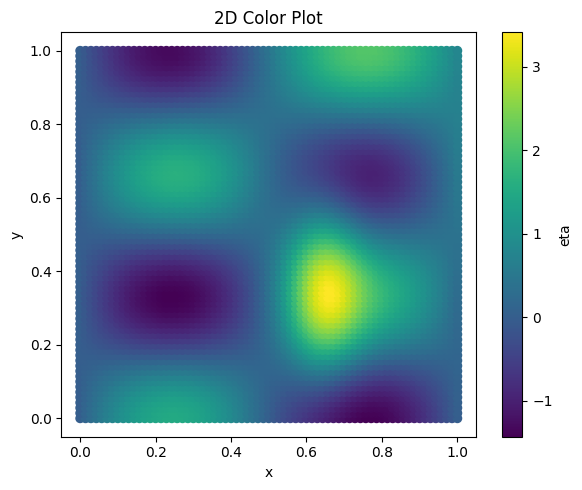

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [30]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [31]:
tb = gam.TermBuilder.from_df(df)

In [32]:
loc += (
    tb.ti(
        "x",
        "y",
        k=10,
        scale=gam.ScaleIG(1.0, 1.0, 0.0005),
    ),
    tb.ps("x", k=20),
    tb.ps("y", k=20),
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


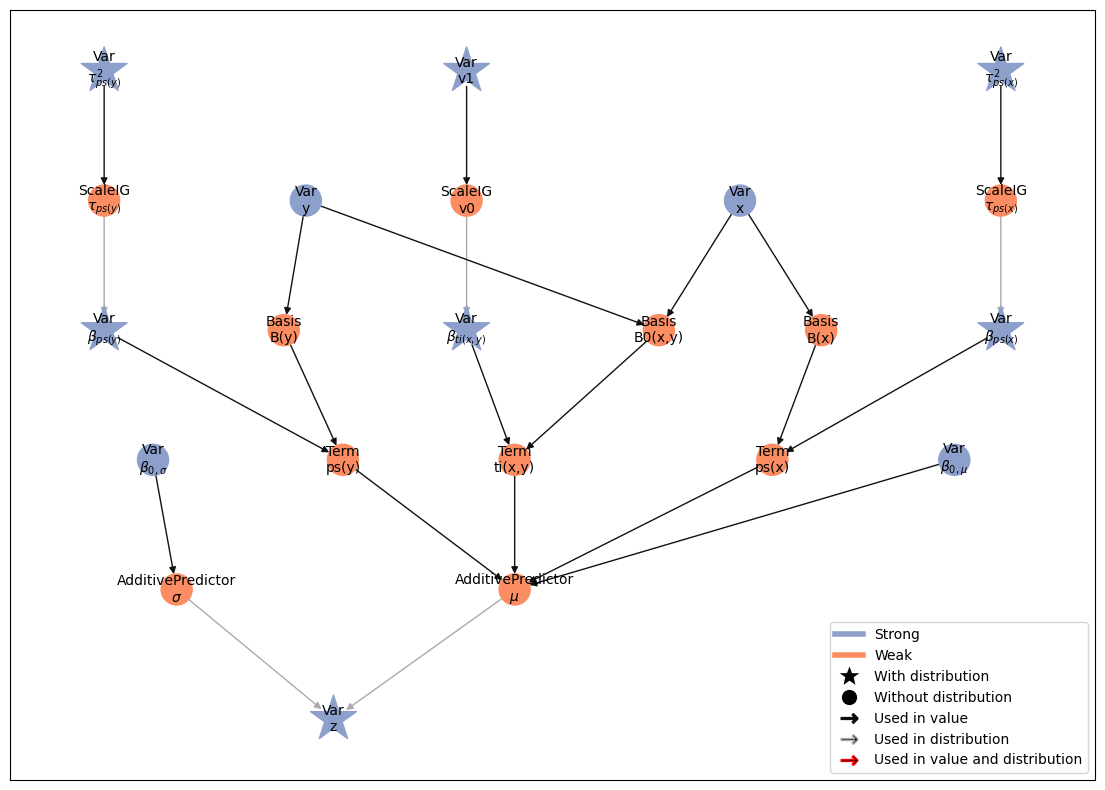

In [33]:
model = lsl.Model([z])
model.plot_vars()

In [34]:
model, bases_model = consolidate_bases(model)

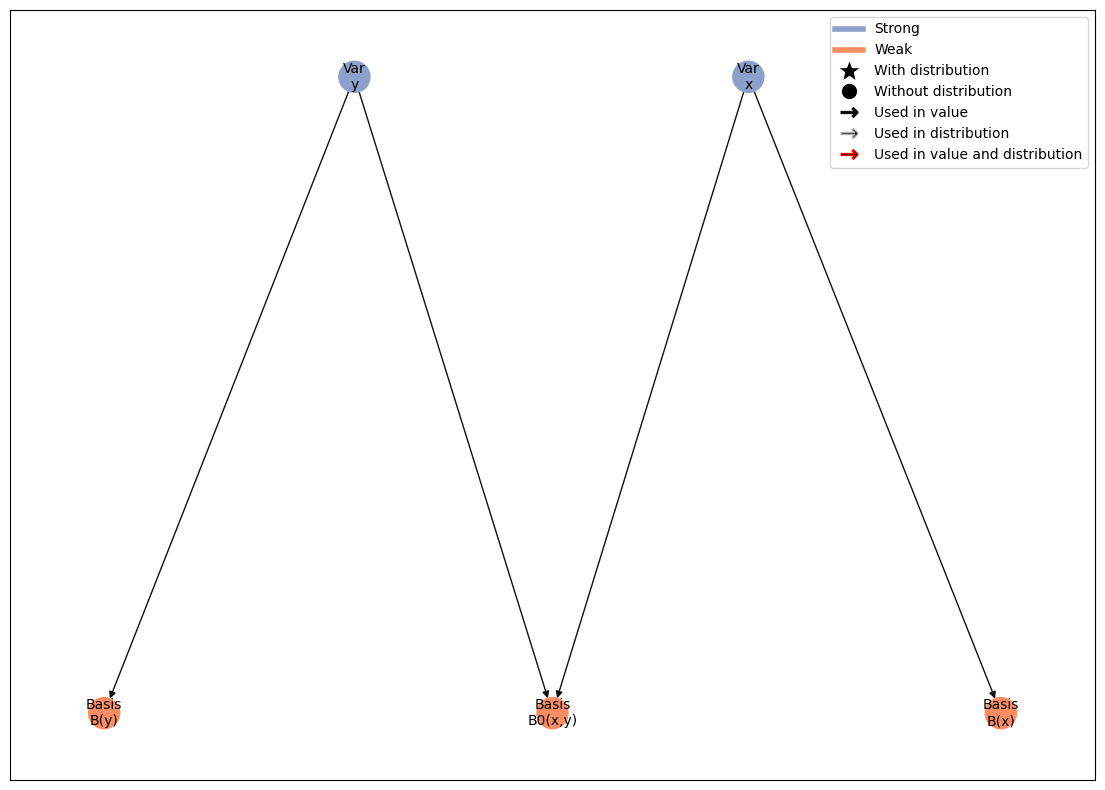

In [35]:
bases_model.plot_vars()

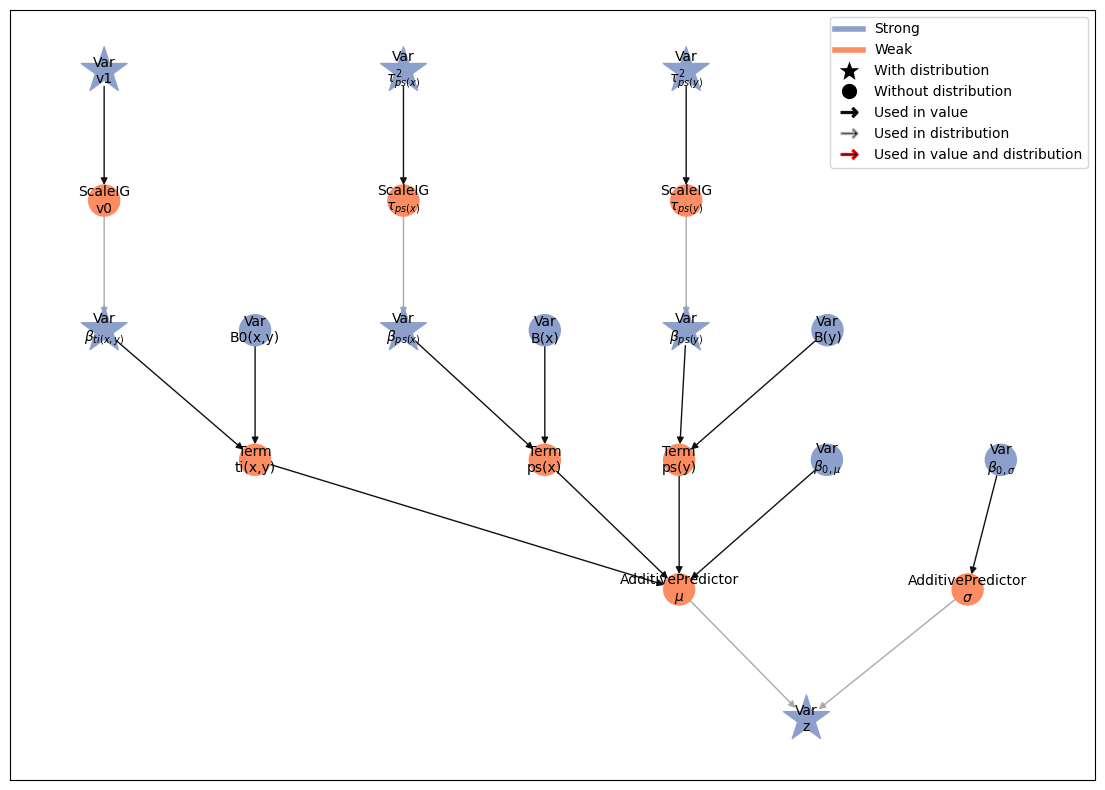

In [36]:
model.plot_vars()

In [37]:
import optax

params = [p.name for p in model.parameters.values() if not p.name.startswith("$\\tau")]
opt = gs.optim_flat(
    model, params, optimizer=optax.adam(learning_rate=1e-5), progress_bar=False
)

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [38]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=1000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'v1', '$\\beta_{ti(x,y)}$', '$\\tau^2_{ps(x)}$', '$\\beta_{ps(x)}$', '$\\tau^2_{ps(y)}$', '$\\beta_{ps(y)}$', '$\\beta_{0,\\mu}$', '$\\beta_{0,\\sigma}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:05<00:00,  1.43chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 877.84chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1122.37chunk/s]
lie

### MCMC summary

In [39]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{0,\mu}$    ()     kernel_06  0.338727  0.011456  0.320254  0.338745   
$\beta_{0,\sigma}$ ()     kernel_07 -1.346798  0.032808 -1.402081 -1.346270   
$\beta_{ps(x)}$    (0,)   kernel_03  0.000397  0.067251 -0.106516  0.000491   
                   (1,)   kernel_03 -0.024373  0.065508 -0.134876 -0.018517   
                   (2,)   kernel_03  0.001782  0.061219 -0.101728  0.001659   
...                             ...       ...       ...       ...       ...   
$\beta_{ti(x,y)}$  (79,)  kernel_01  0.653063  0.244626  0.256587  0.656049   
                   (80,)  kernel_01  1.496863  0.725882  0.211430  1.476187   
$\tau^2_{ps(x)}$   ()     kernel_02  0.004809  0.002438  0.002133  0.004178   
$\tau^2_{ps(y)}$   ()     kernel_04  0.002028  0.001278  0.000787  0.001685   
v1                 ()     kernel_00  0.105990  0.018107  0.078126  0.105090   

                            q_0.95  sample_size    ess_bulk    ess_tail  \
parameter          index                                                  
$\beta_{0,\mu}$    ()     0.357549          800  620.912396  635.682458   
$\beta_{0,\sigma}$ ()    -1.293697          800  690.558652  697.857090   
$\beta_{ps(x)}$    (0,)   0.110466          800  426.797187  572.025995   
                   (1,)   0.077738          800  445.374788  505.239939   
                   (2,)   0.103501          800  431.876634  443.789355   
...                            ...          ...         ...         ...   
$\beta_{ti(x,y)}$  (79,)  1.055811          800  116.489578  213.004943   
                   (80,)  2.794196          800   37.990430   42.679733   
$\tau^2_{ps(x)}$   ()     0.009354          800  284.592136  504.167595   
$\tau^2_{ps(y)}$   ()     0.004334          800  201.705697  344.096339   
v1                 ()     0.137137          800  424.794901  772.976191   

                              rhat  
parameter          index            
$\beta_{0,\mu}$    ()     0.998473  
$\beta_{0,\sigma}$ ()     1.000527  
$\beta_{ps(x)}$    (0,)   1.007965  
                   (1,)   1.005757  
                   (2,)   1.008922  
...                            ...  
$\beta_{ti(x,y)}$  (79,)  1.021719  
                   (80,)  1.053107  
$\tau^2_{ps(x)}$   ()     1.006628  
$\tau^2_{ps(y)}$   ()     1.024681  
v1                 ()     1.000121  

[124 rows x 10 columns]

## Predictions

In [40]:
samples = results.get_posterior_samples()

In [41]:
newdata = {"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()}
newdata = evaluate_bases(newdata, bases_model)

### Predict variables at new x values

In [42]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["ti(x,y)", "$\\mu$", "ps(x)", "ps(y)"],
    newdata=newdata,
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0

In [43]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [44]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x,y
0,$\mu$,$\mu$[0],"(0,)",800,0.216043,0.233365,0.483078,70.127041,212.581287,0.057789,0.023315,1.035168,-0.608771,0.203334,1.003549,-0.528200,1.042406,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",800,-0.137560,0.205377,0.453186,57.681341,156.493239,0.059599,0.027309,1.068287,-0.893190,-0.140926,0.642224,-0.798368,0.713865,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",800,-0.320947,0.310214,0.556969,70.708155,132.331248,0.066293,0.028539,1.059120,-1.275922,-0.311945,0.549224,-1.222974,0.595387,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",800,-0.352644,0.405850,0.637064,81.126582,173.995785,0.070439,0.031899,1.050668,-1.404775,-0.336204,0.682117,-1.459405,0.604026,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",800,-0.260962,0.433644,0.658517,88.264738,191.555277,0.069838,0.033227,1.045557,-1.344043,-0.246832,0.811769,-1.377089,0.770766,0.057143,0.0


### Plot fitted functions

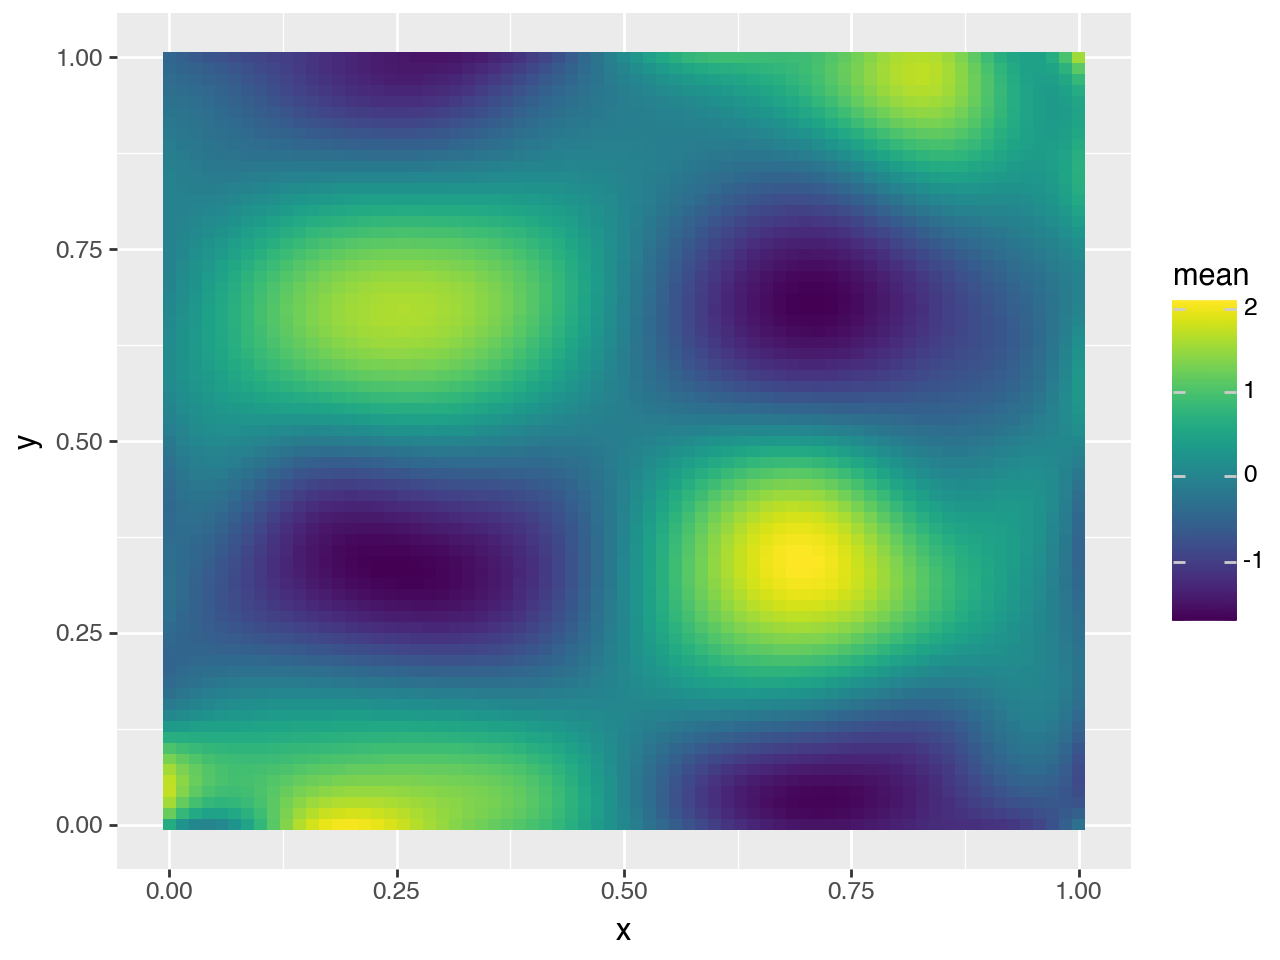

In [45]:
select = predictions_summary["variable"].isin(["ti(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

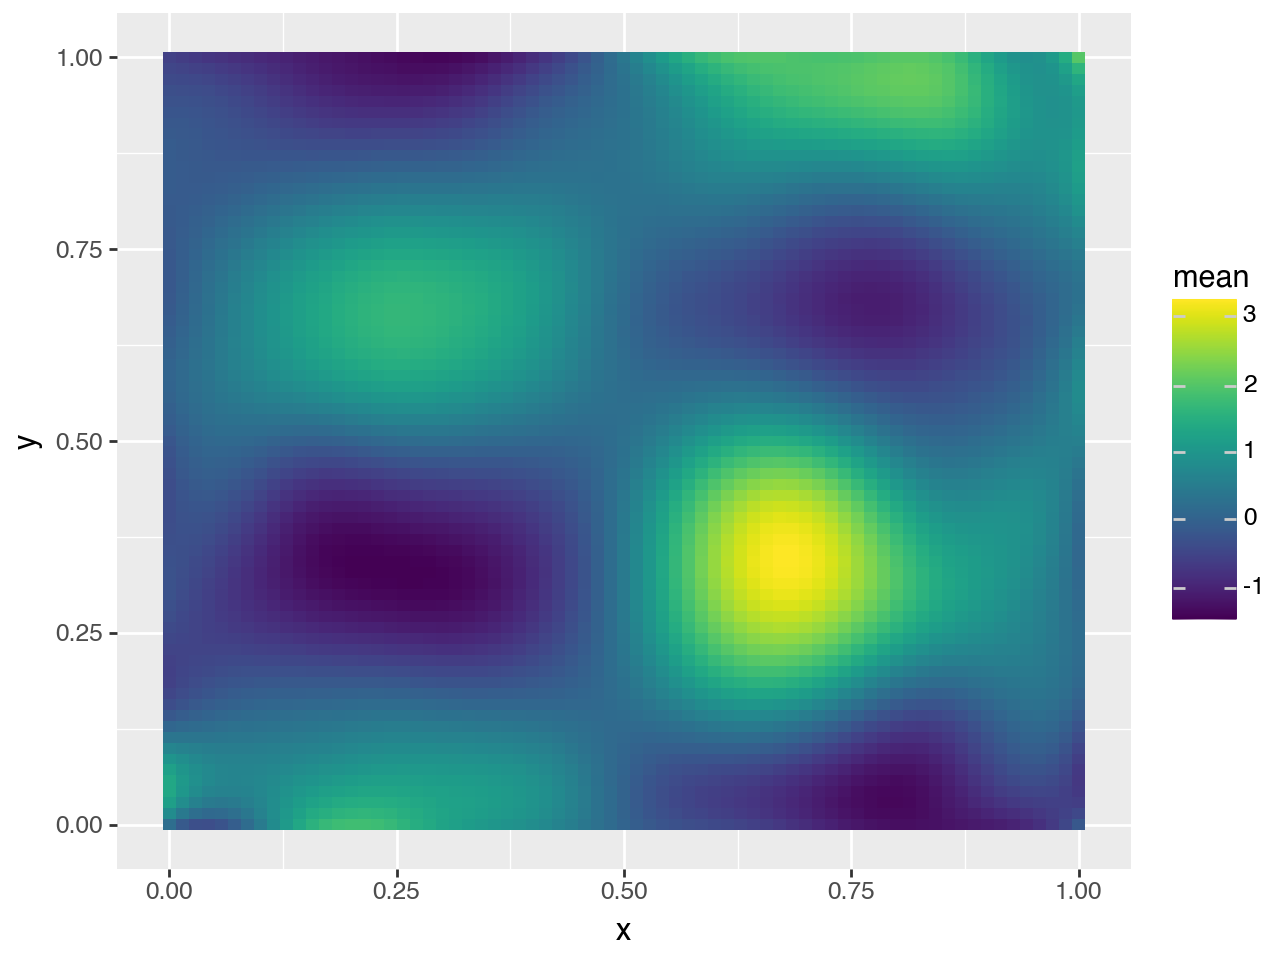

In [46]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

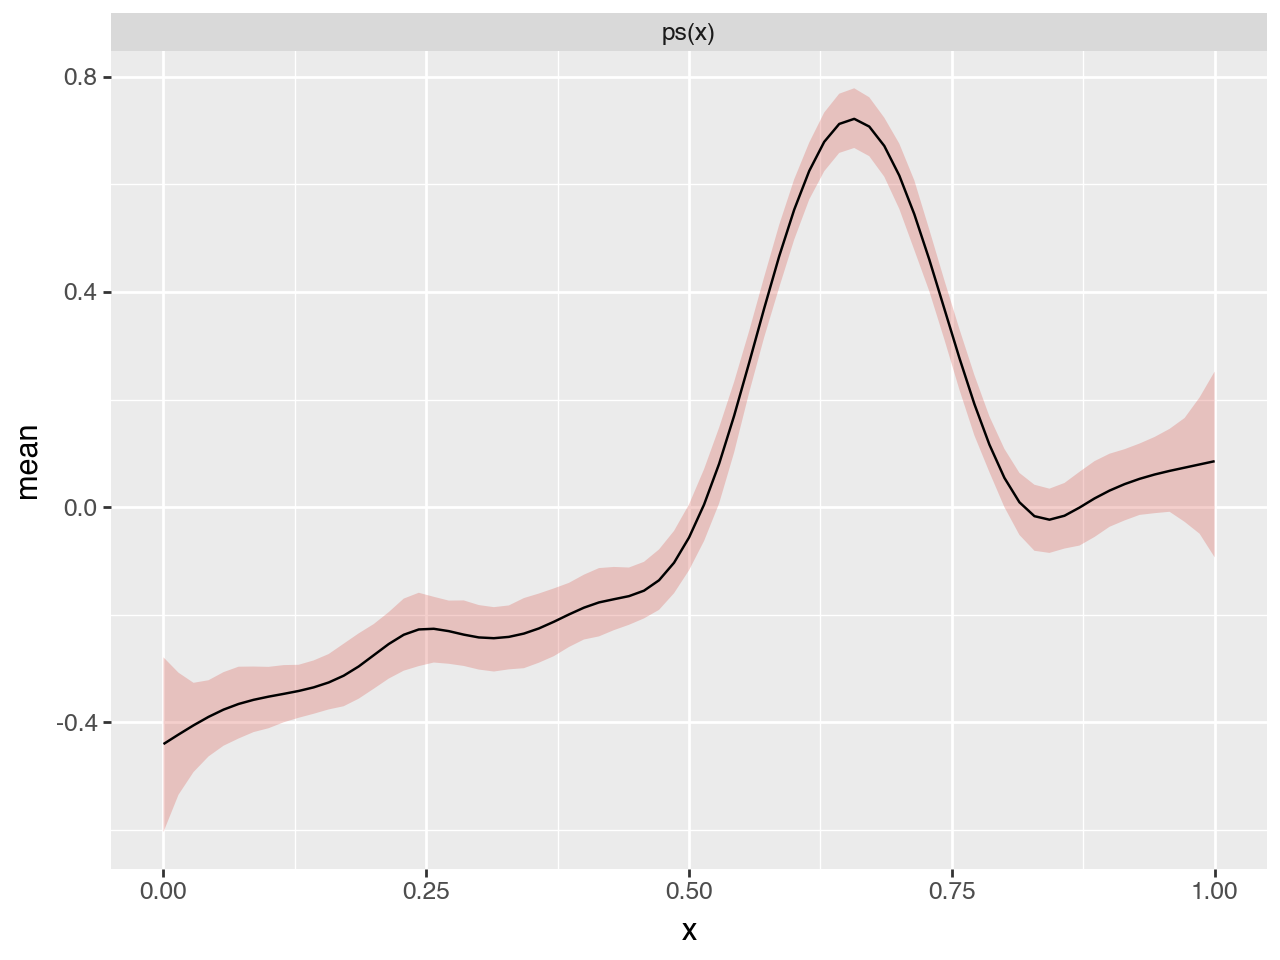

In [47]:
select = predictions_summary["variable"].isin(["ps(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

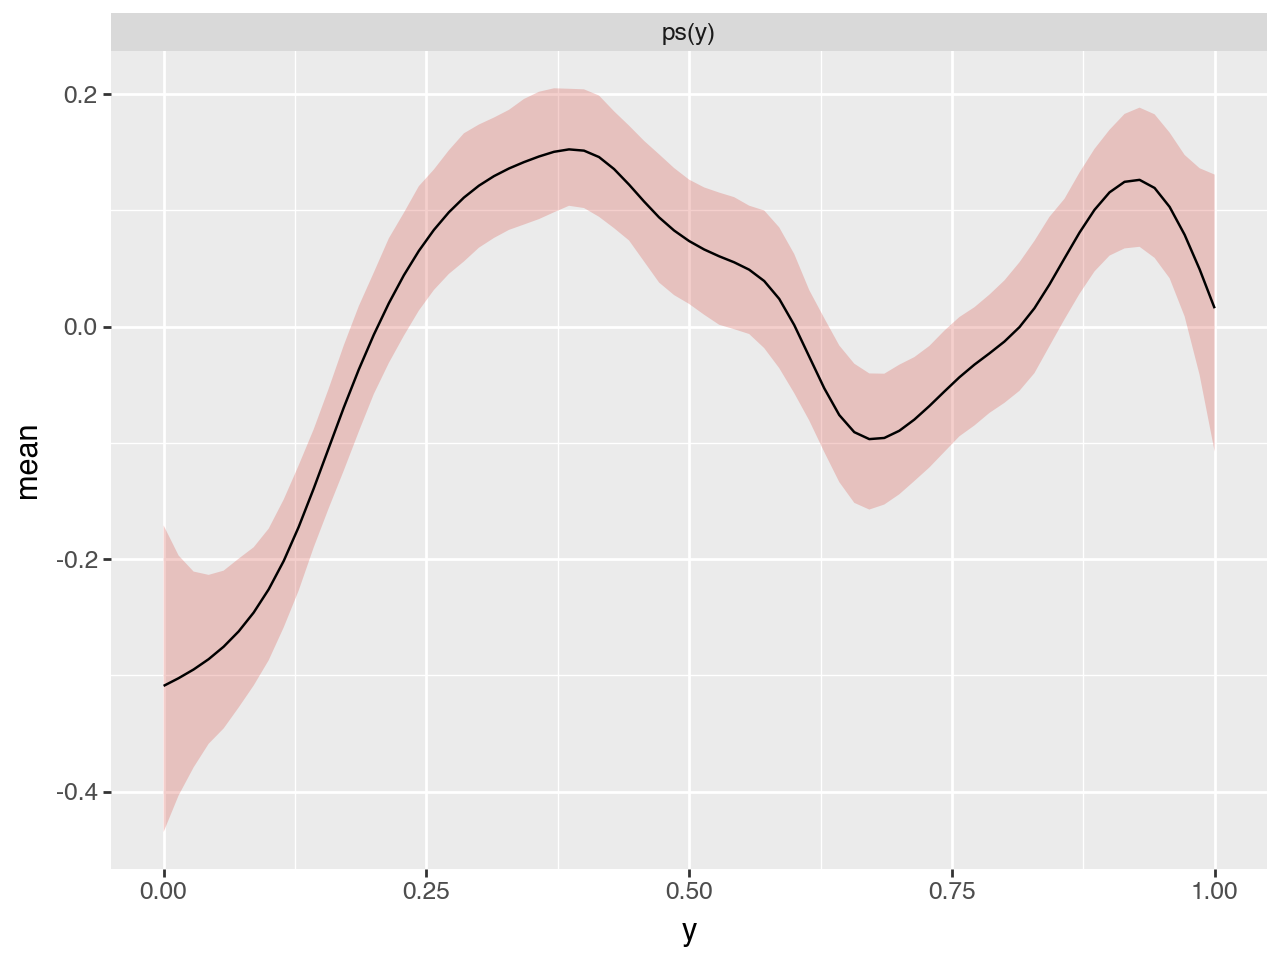

In [48]:
select = predictions_summary["variable"].isin(["ps(y)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("y", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("y", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)